In [73]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import itertools
import random
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader

In [2]:
def train_Rt(enc,dec,q,x_data,opt,Rt,N_EPOCHS=500,lr_b = 0.1):
    #Train parameters of VAE specified in `opt`
    history = { "loss" : [],
                "distortion" : [],
                "rate" : [],
                "beta" : [1]   }

    for e in range(N_EPOCHS):
        lav = dav = rav = 0
        beta = history["beta"][-1]
        for x_ in x_data:
            rate = q(enc,x_)
            distortion = distortion_analytical_linear(x_,enc,dec,q.r_all)
            loss =  distortion +beta*rate
            opt.zero_grad()
            loss.backward()
            opt.step()
            lav += distortion + rate
            dav += distortion
            rav += rate
        history["loss"].append(lav.item()/len(x_data))
        history["rate"].append(rav.item()/len(x_data))
        history["distortion"].append(dav.item()/len(x_data))
        #Update constraint
        beta += lr_b*(history["rate"][-1]-Rt)
        beta = beta if beta>0 else 0
        history["beta"].append(beta)
        print(f'Epoch: {e} ||Rate: {history["rate"][-1]}||',
            f'ELBO:{history["loss"][-1]}||',
            f'Distortion: {history["distortion"][-1]}||Beta = {history["beta"][-1]}')
    history["beta"].pop()
    return history

In [77]:
#Architecture parameters and distributions of stimuli
N = 10
K = 5
M = 100
w = torch.distributions.Categorical(torch.tensor([0.5,0.5,0.5]))
gs = torch.distributions.normal.Normal(torch.Tensor([-2,2,4]),torch.tensor([1,1,0.8]))
p_x = torch.distributions.mixture_same_family.MixtureSameFamily(w,gs)
p_x = torch.distributions.log_normal.LogNormal(1,1)
#Training parameters.
#PRE_EPOCHS = 100
N_EPOCHS = 500
N_SAMPLES =10000
lr = 1e-3
BATCH_SIZE = 200
#Generate dataset
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_test = p_x.sample((10000,))[:,None]
x_tsorted,_ = x_test.sort(dim=0)
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
p_x.entropy()

tensor(2.4189)

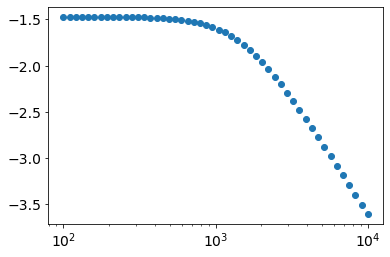

In [6]:
A = 2.4e6
f0 = 1.52e3
p = 2.61
density = lambda f :  A/(f0**p + f**p)
fs = torch.logspace(2, 4,steps=50)
pf = density(fs)
pf /= pf.sum()
plt.scatter(fs,torch.log10(pf))
plt.xscale("log")
d = torch.distributions.categorical.Categorical(probs = pf)
x_samples = fs[d.sample((N_SAMPLES,))[:,None]]
x_test = fs[d.sample((50000,))[:,None]]
x_tsorted,_ = x_test.sort(dim=0)
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)
x_fine = torch.linspace(x_min,x_max,1000)[:,None]

Text(0, 0.5, 'Encoding')

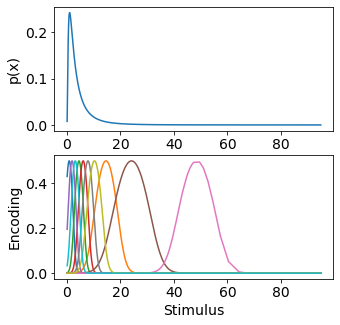

In [76]:
#Initialize model parameters
enc = BernoulliEncoder(N,x_min-1,x_max+1,x_sorted)
#with torch.no_grad():
#    enc.cs += np.sqrt(0.)*torch.randn(N)
cs_sorted,indices = enc.cs.sort(dim=1)
indices = torch.squeeze(indices)
idr = np.argsort(indices)
deltac = torch.diff(cs_sorted)
deltac = torch.cat((deltac[0,:],deltac[:,-1]))
#enc.cs = torch.nn.Parameter(torch.Tensor(np.linspace(x_min,x_max,num=N))[None,:])
#enc.As = torch.nn.Parameter(5*torch.ones(N)[None,:])
enc.log_sigmas = torch.nn.Parameter(torch.log(torch.ones(N)*torch.sqrt(deltac))[None,idr])
q = rate_ising(N)
#q = rate_vampBernoulli(K,x_fine)
#x_k = x_fine[random.sample(range(1000),K)]
#q.x_k = torch.nn.Parameter(x_k)
q.J.register_hook(lambda grad: grad.fill_diagonal_(0))
dec = MLPDecoder2n(N,M)
fig,axs = plt.subplots(2,1,figsize=(5,5))
axs[0].plot(x_sorted,torch.exp(p_x.log_prob(x_sorted)).detach())
axs[0].set_xlabel("Stimulus")
axs[0].set_ylabel("p(x)")
#axs[0].plot(h.bin_edges[0:-1],torch.log10(h.hist))
#axs[0].set_xscale("log")
axs[1].plot(x_sorted,torch.sigmoid(enc(x_sorted)).detach())
axs[1].set_xlabel("Stimulus")
axs[1].set_ylabel("Encoding")
#axs[1].set_xscale("log")

In [78]:
params =   list(enc.parameters()) + list(dec.parameters())  + list(q.parameters())
opt = torch.optim.Adam(params,1e-3)
Rt = 2.
history = train_Rt(enc,dec,q,x_data,opt,Rt,N_EPOCHS = 2000,lr_b = 0.1)

Epoch: 0 ||Rate: 1.9906488037109376|| ELBO:18.742257080078126|| Distortion: 16.751607666015627||Beta = 0.9990648803710938
Epoch: 1 ||Rate: 1.7112062072753906|| ELBO:8.93479736328125|| Distortion: 7.22359130859375||Beta = 0.9701855010986328
Epoch: 2 ||Rate: 1.521144256591797|| ELBO:6.1999273681640625|| Distortion: 4.678783264160156||Beta = 0.9222999267578125
Epoch: 3 ||Rate: 1.380335235595703|| ELBO:4.967305908203125|| Distortion: 3.5869708251953125||Beta = 0.8603334503173827
Epoch: 4 ||Rate: 1.2715164947509765|| ELBO:4.2695486450195315|| Distortion: 2.998032531738281||Beta = 0.7874850997924804
Epoch: 5 ||Rate: 1.1881306457519532|| ELBO:3.8681814575195315|| Distortion: 2.680050964355469||Beta = 0.7062981643676757
Epoch: 6 ||Rate: 1.1239068603515625|| ELBO:3.606791687011719|| Distortion: 2.4828846740722654||Beta = 0.618688850402832
Epoch: 7 ||Rate: 1.0746778869628906|| ELBO:3.422748718261719|| Distortion: 2.348070526123047||Beta = 0.526156639099121
Epoch: 8 ||Rate: 1.0387052154541017|| E

In [81]:
resume = { 'encode' :enc.state_dict(),
            'decoder' : dec.state_dict(),
            'q'      : q.state_dict(),
            'history' : history,
            'Rt'      : Rt,
            'x_test'  : x_tsorted
}
PATH = os.getcwd() + "/data/try_ln.pt"
torch.save(resume, PATH)

In [82]:
d = torch.load(PATH)
d.keys()

dict_keys(['encode', 'decoder', 'q', 'history', 'Rt', 'x_test'])

(0.0, 10.0)

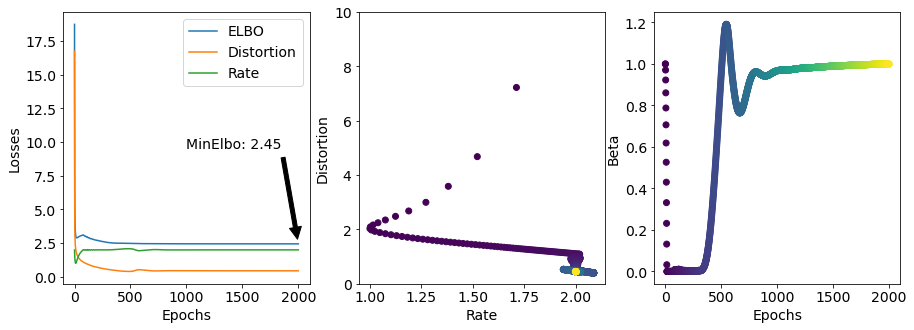

In [83]:
fig,ax = training_plots(history["loss"],history["distortion"],history["rate"],history["beta"])
ax[1].set_ylim(0,10)
#fig.savefig("beta1_training.pdf")

In [1]:
fig,axs = encoder_plots(enc,x_fine)
axs[0].set_xscale("log")
#fig.savefig("beta1_encoder.pdf")

NameError: name 'encoder_plots' is not defined

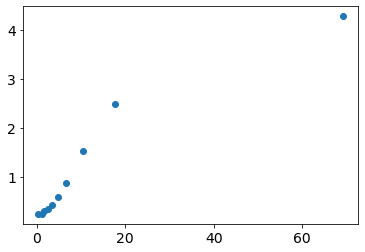

In [85]:
with torch.no_grad():
    plt.scatter(enc.cs, torch.exp(enc.log_sigmas))
    #plt.xscale("log")

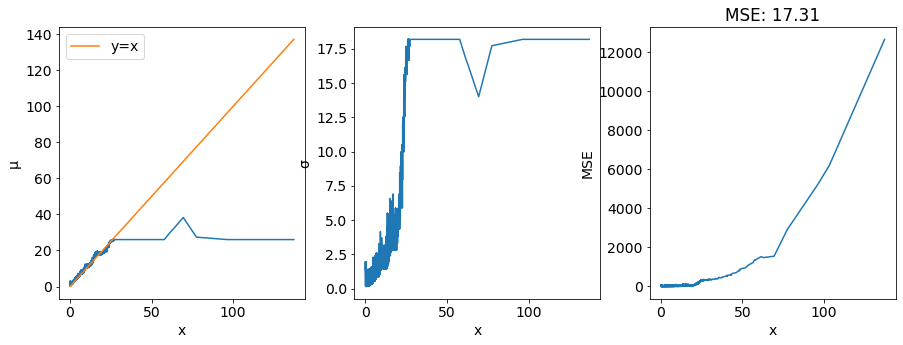

In [86]:
fig,axs = decoder_plots(enc,dec,x_tsorted)
#axs[2].set_xscale("log")
#axs[2].set_yscale("log")
#fig.savefig("beta1_decoder.pdf")

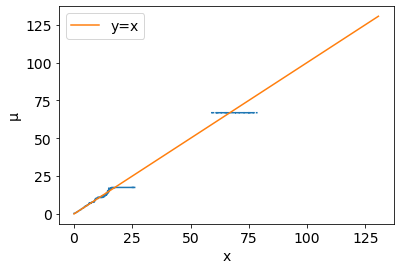

In [87]:
with torch.no_grad():
    r = enc.sample(x_fine,15)
    mu_dec,log_sigma_dec = dec(r)
    mu_dec = torch.where((r.sum(dim=2)) >0,mu_dec.double(),float('nan'))
    x_ext = dec.sample(r,10)
    mseVec = ((x_ext - x_fine[None,:])**2).mean(dim=(0,2))
    fig,axs = plt.subplots()
    axs.plot(x_fine,mu_dec.nanmean(dim=1))
    axs.plot(x_fine,x_fine,label="y=x")
    axs.legend()
    axs.set_xlabel('x')
    axs.set_ylabel('μ')
    

(0.0, 30.0)

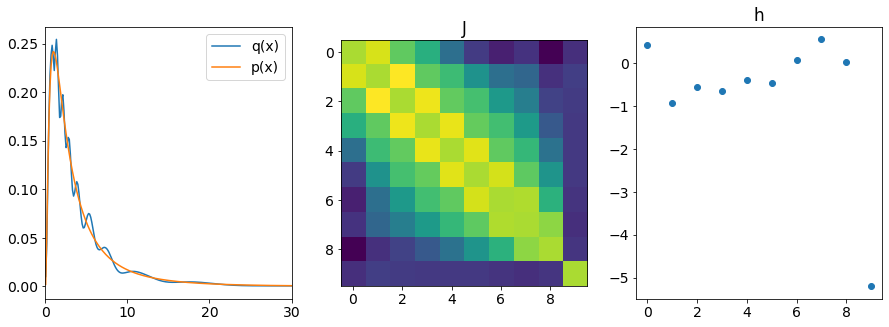

In [95]:
_,indices = enc.cs.sort(dim=1)
indices = torch.squeeze(indices)
fig,axs = generative_model_analytical_plots(q,dec,p_x,x_fine,indices)
axs[0].set_xlim(0,30)
#fig.savefig("beta1_gm.pdf")

NameError: name 'fs' is not defined

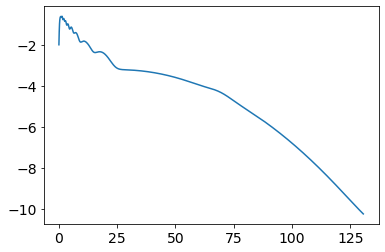

In [89]:
with torch.no_grad():
    mu_dec_all,log_sigma_all = dec(q.r_all.transpose(0,1)[:,None,:])
    q_r = torch.softmax(q.h@q.r_all + (q.r_all*(q.J@q.r_all)).sum(dim=0),1)
    wq = torch.distributions.Categorical(q_r)
    gsq = torch.distributions.normal.Normal(mu_dec_all,torch.exp(log_sigma_all))
    q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
    fig,axs = plt.subplots()
    axs.plot(x_fine,torch.log10(torch.exp(q_x.log_prob(x_fine))),label= "q(x)")
    axs.plot(fs,torch.log10(pf),label= "p(x)")
    axs.legend()
    axs.set_xscale("log")

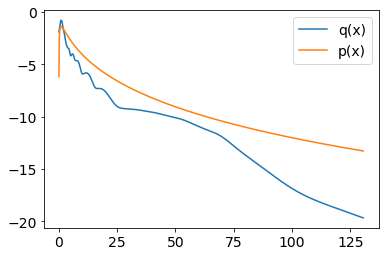

In [94]:
with torch.no_grad():
    mu_dec_all,log_sigma_all = dec(q.r_all.transpose(0,1)[:,None,:])
    q_r = torch.softmax(q.h@q.r_all ,1)
    wq = torch.distributions.Categorical(q_r)
    gsq = torch.distributions.normal.Normal(mu_dec_all,torch.exp(log_sigma_all))
    q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
    fig,axs = plt.subplots()
    axs.plot(x_fine,q_x.log_prob(x_fine),label= "q(x)")
    axs.plot(x_fine,p_x.log_prob(x_fine),label= "p(x)")
    axs.legend()
    #axs.set_xscale("log")

In [14]:
q.h

Parameter containing:
tensor([[-0.6964, -3.0539, -2.4880, -2.5792, -1.9167, -3.4530, -2.0450, -4.1790,
         -3.3782, -3.3737]], requires_grad=True)

In [ ]:
x_sorted

tensor([[  4.0389],
        [  4.0825],
        [  4.2851],
        ...,
        [ 97.2659],
        [117.6913],
        [128.2139]])

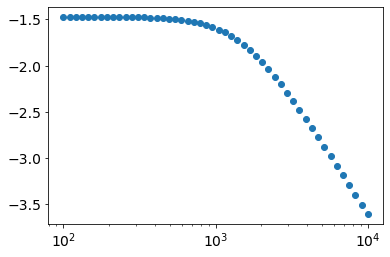

In [222]:
d = torch.distributions.categorical.Categorical(probs = pf)
x = fs[d.sample((100000,))[:,None]]

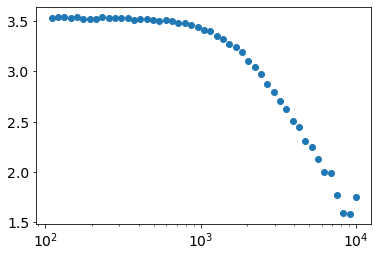

In [226]:
h,b = torch.histogram(x,fs)
plt.scatter(b[1:],torch.log10(h))
plt.xscale("log")

In [261]:
(pf*np.log(pf)).sum()

tensor(-3.6044)

In [26]:
p_x.entropy()

tensor(1.4189)

In [6]:
Rt = 10
a=5
resume = {}
resume[Rt] = a
resume

{10: 5}

In [55]:
kmeans = cluster.KMeans(n_clusters=N, init='random',
                        n_init=10, max_iter=10, random_state=2)
C = kmeans.fit_predict(x_sorted)

In [18]:
eta = enc(x_samples)
KLs = (torch.sigmoid(eta)*(F.logsigmoid(eta) - F.logsigmoid(q.h)) + 
        torch.sigmoid(-eta)*(F.logsigmoid(-eta) - F.logsigmoid(-q.h))).sum(dim=1)
R = KLs.mean()

In [19]:
R

tensor(1.2434, grad_fn=<MeanBackward0>)